# NLP Project
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset 

## 1. Import Libraries/Dataset
**1.1.1. Import the required libraries**

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re, string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

**1.1.2. Import Dataset**

In [ ]:
true = pd.read_csv("./Data/True.csv")
false = pd.read_csv("./Data/Fake.csv")

**1.2. Check the GPU available**

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## 2. Data Visualization

**2.1. Print at least two records from each class of the dataset, for a sanity check that labels match the text.**

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


**2.2. Plot a bar graph of class distribution in the dataset. Each bar depicts the number of records belonging to a particular class in the dataset.**

In [ ]:
true['category'] = 1
false['category'] = 0

In [ ]:
df = pd.concat([true,false])

<AxesSubplot:xlabel='category', ylabel='count'>

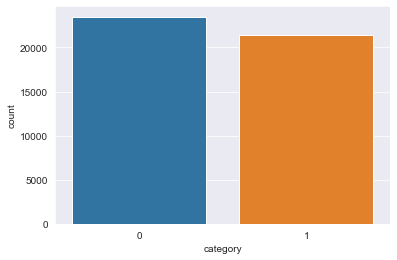

In [ ]:
sns.set_style("darkgrid")
sns.countplot(x = "category", data=df)

It shows the number of records for each class. From this figure, we can see that the are alomst same records for each class and we can apply ML without any SMOTE.

**2.3. Other Visualizations**

Concat Dataset

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
df.title.count()

44898

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Subject Count

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

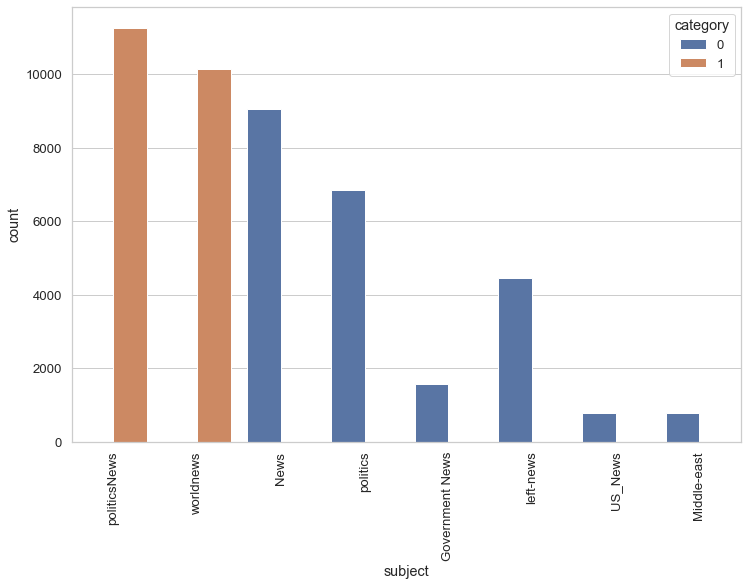

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

This shows the number of subject. This category doesn’t use for this project only for visualization.

**2.4. 4.Print the shapes of train and test data.**

In [ ]:
df_train, df_test = train_test_split(df,random_state = 0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33673 entries, 13637 to 2732
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     33673 non-null  object
 1   text      33673 non-null  object
 2   subject   33673 non-null  object
 3   date      33673 non-null  object
 4   category  33673 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11225 entries, 13888 to 19877
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     11225 non-null  object
 1   text      11225 non-null  object
 2   subject   11225 non-null  object
 3   date      11225 non-null  object
 4   category  11225 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 526.2+ KB


## 3. Data Pre-processing

**3.1. Data Cleanning**

Remove unnecessary columns from dataframe

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
    
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
    
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

**3.2. Use Pre-trained embedding layer**

https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt

Use the pre-trained embedding layer(https://www.kaggle.com/bertcarremans/glovetwitter27b100dtxt). This dataset contain 100-dimensional word embeddings of tweets.

In [ ]:
EMBEDDING_FILE = './Data/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, errors="ignore"))

**3.3. Get training and testing data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


## 4. Model Building

**Some Model Parameters**

In [ ]:
batch_size = 256
epoch_num = 5
embed_size = 100

**4.1. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each.**

In [ ]:
def createModel(params):
    #Defining Neural Network
    model = Sequential()
    #Non-trainable embeddidng layer
    model.add(Embedding(max_features, output_dim = embed_size, weights = [embedding_matrix], input_length = maxlen, trainable = False))
    #LSTM 
    model.add(LSTM(units=params[0] , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25, kernel_regularizer = 'l2'))
    model.add(LSTM(units=params[1] , recurrent_dropout = 0.1 , dropout = 0.1, kernel_regularizer = 'l2'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer = 'l2'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = params[2]), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

Find the best units of hidden layes and learning rate

In [ ]:
param_set = [[128, 64, 0.05],[128, 64, 0.01], [64, 32, 0.05],[64, 32, 0.01]]
val_acc = []
for params in param_set:
    model = createModel(params)
    model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 1)
    val_acc.append(model.evaluate(X_test, y_test)[1]*100)

351/351 [==============================] - 38s 108ms/step - loss: 0.1728 - accuracy: 0.9787


Select the best Model

In [ ]:
print(val_acc)

[60.09799838066101, 72.90868759155273, 90.47661423683167, 96.70378565788269]


This shows the test accuracies for various combination of hyperparameters. From this table, (64, 32, 0.01) are selected as the best hyperparamters.

In [ ]:
param_index = val_acc.index(max(val_acc))
params = param_set[param_index]
print(params)

[64, 32, 0.01]


In [ ]:
model = createModel(params)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_8 (LSTM)               (None, 300, 64)           42240     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,054,689
Trainable params: 54,689
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epoch_num)

Epoch 1/5
132/132 [==============================] - 686s 5s/step - loss: 0.1438 - accuracy: 0.9812 - val_loss: 0.1060 - val_accuracy: 0.9898
Epoch 2/5
 92/132 [===================>..........] - ETA: 3:19 - loss: 0.1322 - accuracy: 0.9824

## Calculate the train and test accuracy using trained model

In [ ]:
train_acc = model.evaluate(x_train, y_train)[1]*100
test_acc = model.evaluate(X_test, y_test)[1]*100
acc = pd.DataFrame([train_acc, test_acc] , index = ['Train Dataset','Test Dataset'] , columns = ['Accuracy(%)'])
print(acc)

351/351 [==============================] - 31s 88ms/step - loss: 0.1316 - accuracy: 0.9900
               Accuracy(%)
Train Dataset    99.153626
Test Dataset     99.002224


The training and test accuracies of selected model are 99.15% and 99% respectively. 

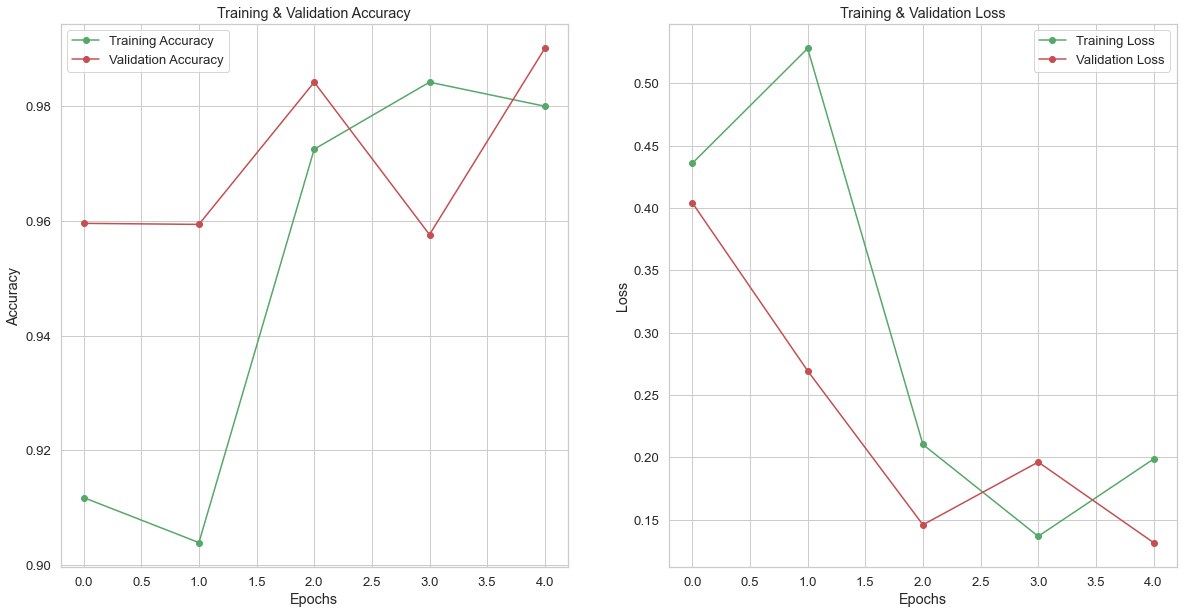

In [ ]:
epochs = [i for i in range(epoch_num)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5858
        Real       0.99      0.99      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Real'] , columns = ['Fake','Real'])

<AxesSubplot:>

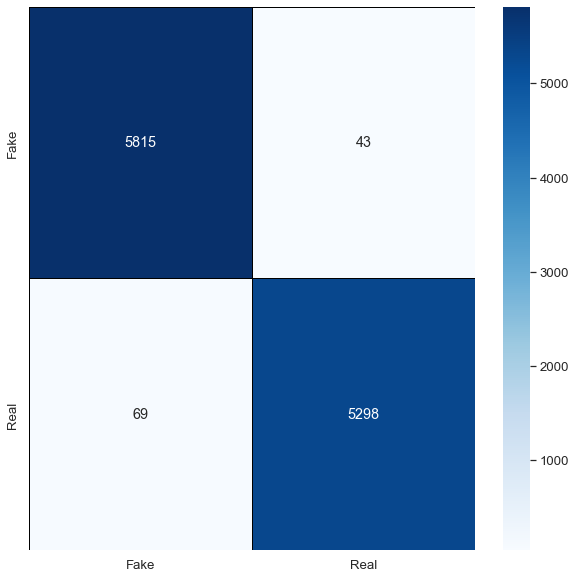

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

## Hyperparameter Tuning

1. Regularization: Train a model without regularization

In [ ]:
model1 = Sequential()
#Non-trainable embeddidng layer
model1.add(Embedding(max_features, output_dim = embed_size, weights = [embedding_matrix], input_length = maxlen, trainable = False))
#LSTM 
model1.add(LSTM(units=params[0] , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model1.add(LSTM(units=params[1] , recurrent_dropout = 0.1 , dropout = 0.1))
model1.add(Dropout(0.25))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = params[2]), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history1 = model1.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epoch_num)

Epoch 1/5
132/132 [==============================] - 611s 5s/step - loss: 0.1347 - accuracy: 0.9440 - val_loss: 0.0301 - val_accuracy: 0.9896 - lr: 0.0100
Epoch 2/5
132/132 [==============================] - 609s 5s/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0150 - val_accuracy: 0.9955 - lr: 0.0100
Epoch 3/5
132/132 [==============================] - 611s 5s/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.0271 - val_accuracy: 0.9930 - lr: 0.0100
Epoch 4/5
132/132 [==============================] - 610s 5s/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0093 - val_accuracy: 0.9971 - lr: 0.0100
Epoch 5/5
132/132 [==============================] - 610s 5s/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0073 - val_accuracy: 0.9978 - lr: 0.0100


In [ ]:
train_acc1 = model1.evaluate(x_train, y_train)[1]*100
test_acc1 = model1.evaluate(X_test, y_test)[1]*100
acc1 = pd.DataFrame([train_acc1, test_acc1] , index = ['Train Dataset','Test Dataset'] , columns = ['Accuracy(%)'])
print(acc1)

351/351 [==============================] - 32s 92ms/step - loss: 0.0073 - accuracy: 0.9978
               Accuracy(%)
Train Dataset    99.943572
Test Dataset     99.777281


The training and test accuracy of the model without regularization are 99.94% and 99.77%. The same hyperparameters are used with first model.

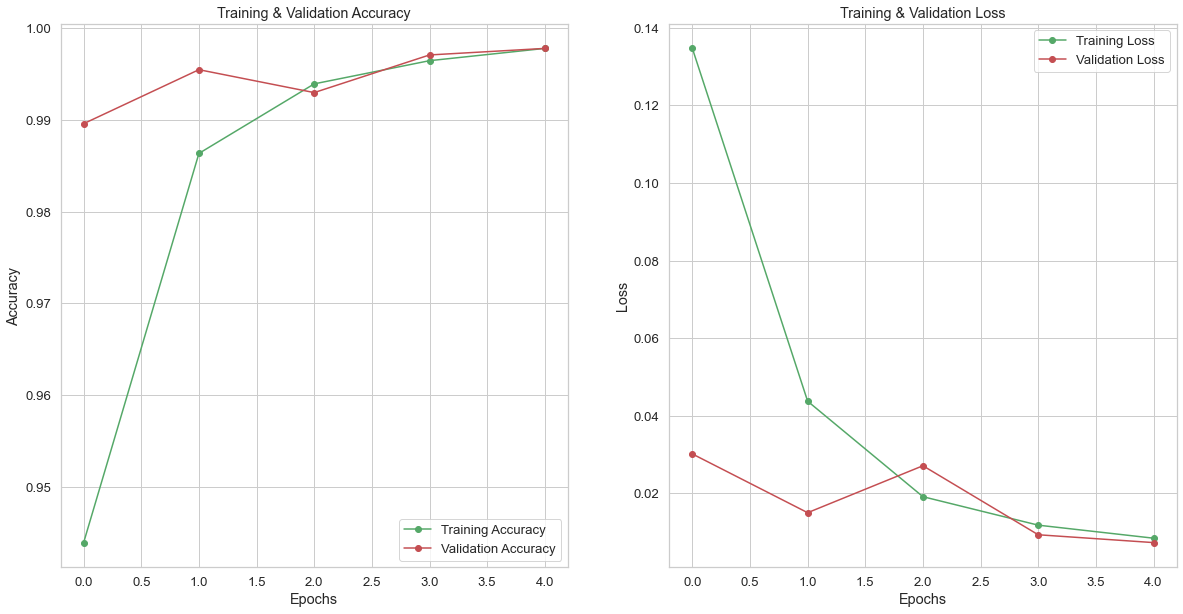

In [ ]:
epochs = [i for i in range(epoch_num)]
fig , ax = plt.subplots(1,2)
train_acc1 = history1.history['accuracy']
train_loss1 = history1.history['loss']
val_acc1 = history1.history['val_accuracy']
val_loss1 = history1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc1 , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc1 , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss1 , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss1 , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred1 = (model1.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred1, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
        Real       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
cm1 = confusion_matrix(y_test,pred1)
cm1 = pd.DataFrame(cm1 , index = ['Fake','Real'] , columns = ['Fake','Real'])

<AxesSubplot:>

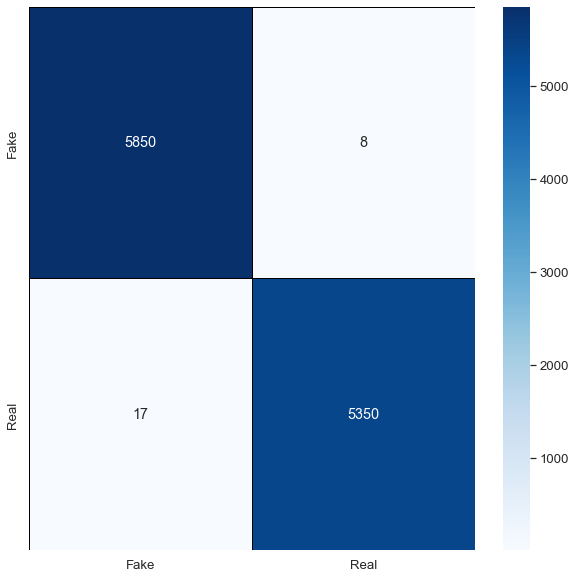

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])

2. Dropout:Change the position and value of dropout layer

In [ ]:
model2 = Sequential()
#Non-trainable embeddidng layer
model2.add(Embedding(max_features, output_dim = embed_size, weights = [embedding_matrix], input_length = maxlen, trainable = False))
#LSTM 
model2.add(LSTM(units=params[0] , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model2.add(Dropout(0.15))
model2.add(LSTM(units=params[1] , recurrent_dropout = 0.1 , dropout = 0.1))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = params[2]), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history2 = model2.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epoch_num , callbacks = [learning_rate_reduction])

Epoch 1/5
132/132 [==============================] - 681s 5s/step - loss: 0.1147 - accuracy: 0.9556 - val_loss: 0.0190 - val_accuracy: 0.9943 - lr: 0.0100
Epoch 2/5
132/132 [==============================] - 699s 5s/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.0240 - val_accuracy: 0.9922 - lr: 0.0100
Epoch 3/5
132/132 [==============================] - 702s 5s/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0118 - val_accuracy: 0.9966 - lr: 0.0100
Epoch 4/5
132/132 [==============================] - 711s 5s/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0107 - val_accuracy: 0.9965 - lr: 0.0100
Epoch 5/5
132/132 [==============================] - 716s 5s/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0102 - val_accuracy: 0.9972 - lr: 0.0100


In [ ]:
train_acc2 = model2.evaluate(x_train, y_train)[1]*100
test_acc2 = model2.evaluate(X_test, y_test)[1]*100
acc2 = pd.DataFrame([train_acc2, test_acc2] , index = ['Train Dataset','Test Dataset'] , columns = ['Accuracy(%)'])
print(acc2)

351/351 [==============================] - 34s 98ms/step - loss: 0.0102 - accuracy: 0.9972
               Accuracy(%)
Train Dataset    99.910909
Test Dataset     99.723828


The training and test accuracy of the model without regularization are 99.91% and 99.72%. The same hyperparameters are used with first model.

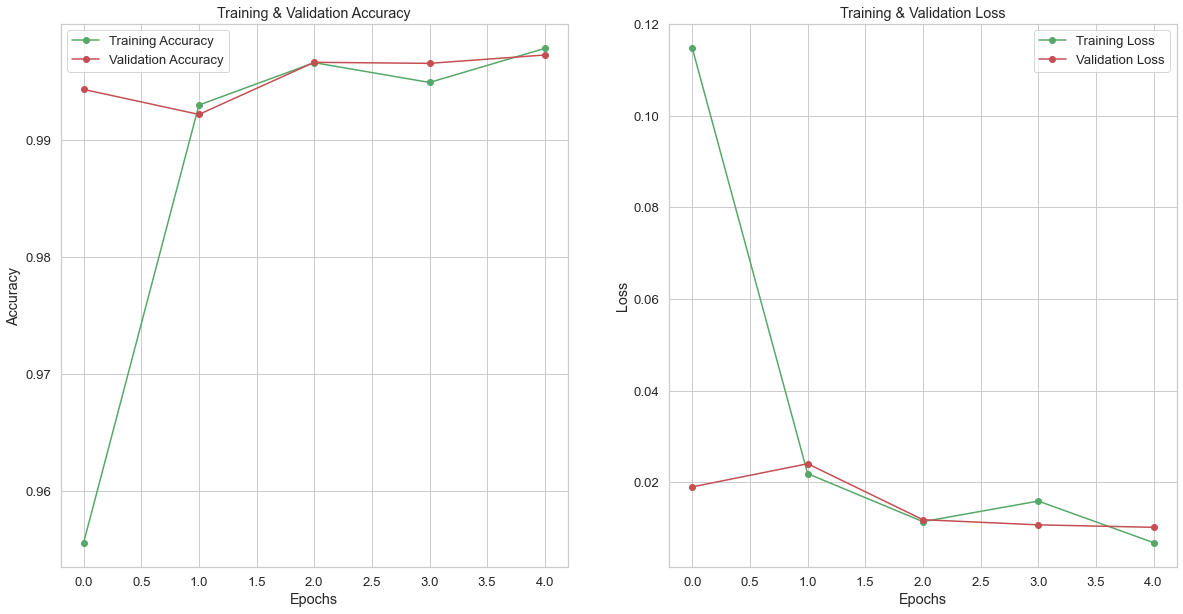

In [ ]:
epochs = [i for i in range(epoch_num)]
fig , ax = plt.subplots(1,2)
train_acc2 = history2.history['accuracy']
train_loss2 = history2.history['loss']
val_acc2 = history2.history['val_accuracy']
val_loss2 = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc2 , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc2 , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss2 , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss2 , 'ro-' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred2 = (model2.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred2, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
        Real       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
cm2 = confusion_matrix(y_test,pred2)
cm2 = pd.DataFrame(cm2 , index = ['Fake','Real'] , columns = ['Fake','Real'])

<AxesSubplot:>

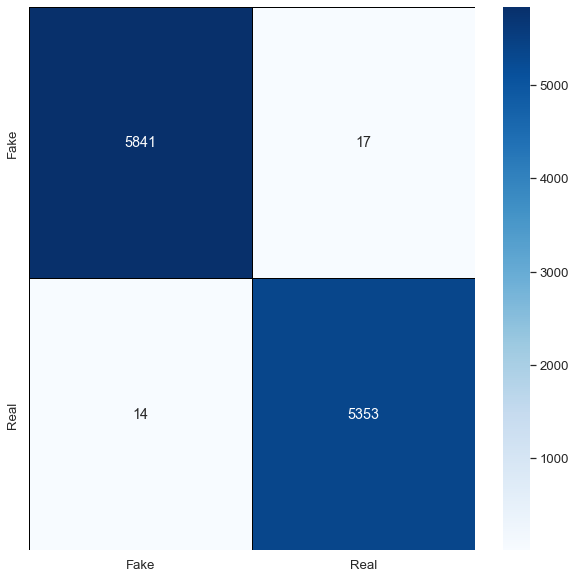

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm2,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])